In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import integrate

from mpl_toolkits.mplot3d import Axes3D

# IBCM with constant $\vec{x}$
Analytical approximation of constant $\vec{x}$ so we can look at a two-variable system, $\Theta$ and $M = \sum_i m_i$

In [2]:
def deriv(t, y, params):
    # y contains M, Theta
    A, B = params
    dy = np.zeros(y.shape)
    dy[0] = A * y[0] * (y[0] - y[1])
    dy[1] = B * (y[0]*y[0] - y[1])
    return dy

In [3]:
def plot_stream(f, xext, yext, params, figax=None, var_names=["x", "y"]):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    
    xx, yy = np.meshgrid(np.linspace(*xext, 101), np.linspace(*yext, 101), indexing="xy")
    dd = f(0.0, np.stack([xx, yy]), params)

    ax.streamplot(xx, yy, dd[0], dd[1], density=3, color='gray', linewidth=0.5)
    ax.set(xlabel=var_names[0], ylabel=var_names[1])
    return [fig, ax]

In [4]:
# Parameters
learnrate = 1 / 4000
tau_avg = 150.0
n_orn = 4
x0 = 1.0
params_ab = [n_orn*learnrate*x0*x0, x0*x0/tau_avg]

In [5]:
print(params_ab)
print((params_ab[1] - params_ab[0])**2 - 4*params_ab[0]*params_ab[1])

[0.001, 0.006666666666666667]
5.444444444444444e-06


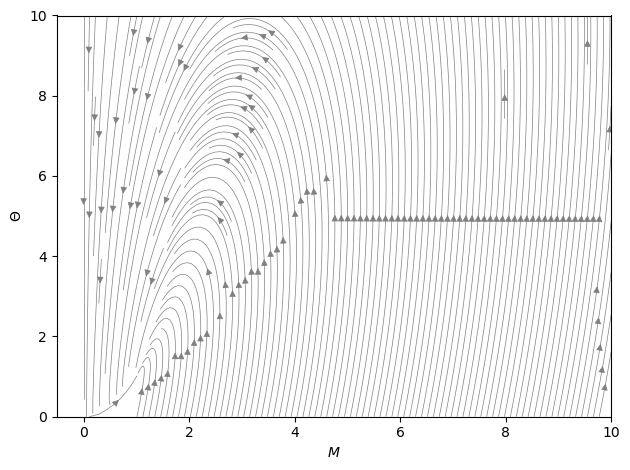

In [6]:
plot_limits = ((0.0, 10.0), (0.0, 10.0))
fig, ax = plot_stream(deriv, *plot_limits, params_ab, var_names=[r"$M$", r"$\Theta$"])
ax.set_xlim()
fig.tight_layout()
xy_init = (0.2, 4.)
xy_init2 = (0.2, 4.5)

plt.show()
plt.close()

# Mean-field model averaged over $\vec{x}$
But still keeping $\Theta$ as a separate variable

Background process with independent $\nu$, all with moments $\sigma^2$ and $m_3$. 

In [7]:
def ibcm_mean_field(t, y, params):
    # Extract relevant variables. 
    # back_vecs contains one background vector per row
    mu, tau, nu0, sigma2, m3, back_vecs = params
    n_r = y.shape[0] - 1
    m = y[:n_r]
    theta = y[-1]
    
    # Compute various terms entering the equations: c_gamma, c_d, etc.
    c_gammas = np.expand_dims(back_vecs.dot(m), 1)
    c_d = np.sum(c_gammas, axis=0, keepdims=True)
    x_d = np.sum(back_vecs, axis=0, keepdims=True)
    sum_cgxg = np.sum(c_gammas * back_vecs, axis=0, keepdims=True)
    
    dy = np.zeros(y.shape)
    dy[:n_r] = mu * (nu0*c_d - theta) * (c_d*nu0*x_d*nu0 + sigma2*sum_cgxg)
    dy[:n_r] += mu * np.sum((sigma2*nu0*c_d*sum_cgxg + nu0*c_gammas*c_gammas*sigma2*x_d
                            + m3 * c_gammas*c_gammas * back_vecs), axis=0)
    dy[-1] = (nu0*nu0*c_d*c_d + sigma2*np.sum(c_gammas*c_gammas, axis=0) - theta) / tau
    return dy

In [8]:
n_components = 3
n_dimensions = 4

learn_rate = 0.002
tau_theta = 150.0
nu_mean = 1.0 / np.sqrt(3)
sigma2_nu = 0.09
m3_nu = 0.0

# Choose three LI vectors in (+, +, +) octant: [0.8, 0.2, 0.2], [0.2, 0.8, 0.2], etc.
back_components = 0.2 * np.ones([n_components, n_dimensions])
for i in range(n_components):
    if i < n_dimensions:
        back_components[i, i] = 0.8
    else:  # If there are more components than there are dimensions (ORNs)
        back_components[i, i % n_dimensions] = 0.8 - i
    # Normalize
    back_components[i] = back_components[i] / np.sqrt(np.sum(back_components[i]**2))
    
# Initial synaptic weights: small positive noise
rgen_meta = np.random.default_rng(seed=0x8549e8fc7718e5fa3e7516addff73b86)
init_synapses = 0.1*rgen_meta.random(size=n_dimensions)
init_theta = 0.1

y_init = np.hstack([init_synapses, init_theta])
parameters = [learn_rate, tau_theta, nu_mean, sigma2_nu, m3_nu, back_components]

In [9]:
res = sp.integrate.solve_ivp(ibcm_mean_field, (0.0, 35000.0), y0=y_init, args=[parameters], 
                             method="RK45", max_step=5.0)

/var/folders/xk/d13rqg5s4rj4gvl0myjd0xbr0000gq/T/ipykernel_8358/2467599070.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dy[-1] = (nu0*nu0*c_d*c_d + sigma2*np.sum(c_gammas*c_gammas, axis=0) - theta) / tau


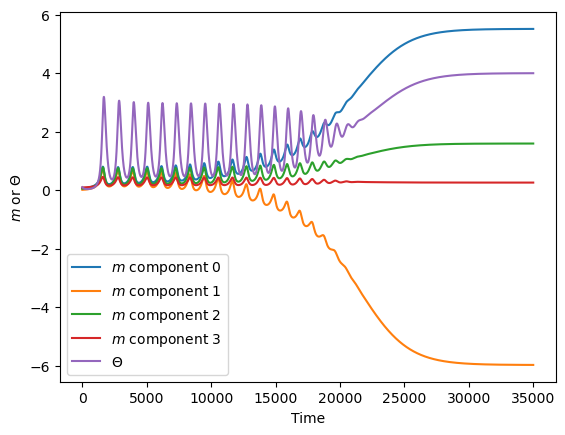

In [10]:
fig, ax = plt.subplots()
for i in range(n_dimensions):
    ax.plot(res.t, res.y[i], label=r"$m$ component {}".format(i))
ax.plot(res.t, res.y[-1], label=r"$\Theta$")
ax.set(xlabel="Time", ylabel=r"$m$ or $\Theta$")
ax.legend()
plt.show()
plt.close()

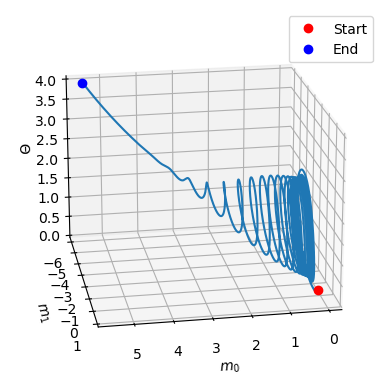

In [11]:
# 3d plot of the trajectory to figure out the phase space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(res.y[0], res.y[1], res.y[-1])
ax.plot(res.y[0, 0], res.y[1, 0], res.y[-1, 0], marker="o", label="Start", color="r", ls="none")
ax.plot(res.y[0, -1], res.y[1, -1], res.y[-1, -1], marker="o", label="End", color="b", ls="none")
ax.view_init(azim=80, elev=20)
ax.set(xlabel=r"$m_0$", ylabel=r"$m_1$", zlabel=r"$\Theta$")
ax.legend()
plt.show()
plt.close()

## Linear stability analysis

In [12]:
# Compute the jacobianfor the equations with sigma^2=0, m3=0
def jacobian_zero_sigma(y, params_sigma0):
    """Parameters when sigma=0 are just mu, tau, nu0, back_vecs"""
    # Initialize variables
    mu, tau, nu0, back_vecs = params_sigma0
    n_orn = back_vecs.shape[1]
    x_d = np.sum(back_vecs, axis=0)
    c_d = y[:n_orn].dot(x_d)
    theta = y[-1]
    
    jac = np.zeros([n_orn+1, n_orn+1])
    
    # Compute the dm_i/dm_j block
    x_d_cov = x_d[:, None] * x_d[None, :]
    jac[:n_orn, :n_orn] = mu*nu0*nu0*(2.0*nu0*c_d - theta)*x_d_cov
    
    # Compute the dTheta/dm_j row
    jac[-1, :n_orn] = 2.0*nu0*nu0*c_d/tau*x_d
    
    # Compute the dm_i/dTheta column
    jac[:n_orn, -1] = -mu*nu0*nu0*c_d*x_d
    
    # Compute the dTheta/dTheta term
    jac[-1, -1] = -1.0 / tau
    
    return jac

In [13]:
# Evaluate it in particular at the fixed point c_d = 1/nu_0/n_orn, theta=1
# and compute its eigenvalues
# Any point such that c_d = 1/nu_0 works; just take all m components equal
# meaning m = 1/sum(x_igamma) / nu0
fixed_pt_sigma0 = np.ones(n_dimensions+1) / np.sum(back_components) / nu_mean
fixed_pt_sigma0[-1] = 1.0
parameters_sigma0 = [learn_rate, tau_theta, nu_mean, back_components]

jacobian_fixed_pt_sigma0 = jacobian_zero_sigma(fixed_pt_sigma0, parameters_sigma0)
print(jacobian_fixed_pt_sigma0)

[[ 0.00126316  0.00126316  0.00126316  0.00063158 -0.00158944]
 [ 0.00126316  0.00126316  0.00126316  0.00063158 -0.00158944]
 [ 0.00126316  0.00126316  0.00126316  0.00063158 -0.00158944]
 [ 0.00063158  0.00063158  0.00063158  0.00031579 -0.00079472]
 [ 0.01059626  0.01059626  0.01059626  0.00529813 -0.00666667]]


In [14]:
eigvals_sigma0 = np.linalg.eigvals(jacobian_fixed_pt_sigma0)

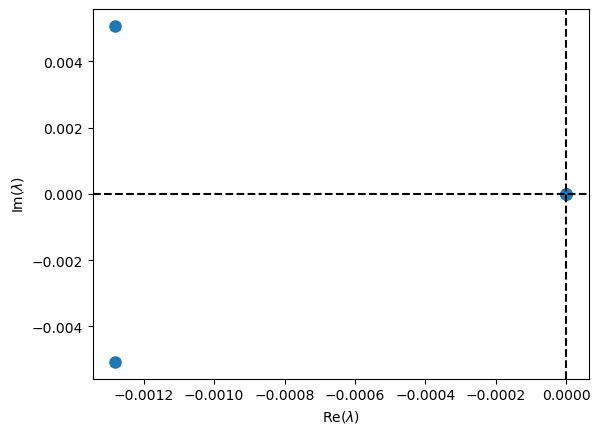

In [15]:
fig, ax = plt.subplots()
ax.axhline(0.0, ls="--", color="k")
ax.axvline(0.0, ls="--", color="k")
ax.scatter(np.real(eigvals_sigma0), np.imag(eigvals_sigma0), s=64)
ax.set(xlabel=r"$\mathrm{Re}(\lambda)$", ylabel=r"$\mathrm{Im}(\lambda)$")
plt.show()
plt.close()

We indeed find a pair of imaginary eigenvalues with negative real parts at the fixed point when $\sigma^2=0$ and $m_3=0$: this is a stable spiral! 

This is due to the particular symmetry of the background vectors I chose. 

Now, the question: does this spiral become unstable when variance is added? How do we even still see this spiral, it's no longer a fixed point? And then how do we compute its stability? 